In [2]:
# data_loaders_and_training.py

# Import necessary libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler, Subset
from torchvision import datasets, transforms
import nbimporter
from model import PneumoniaDetectionCNN
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import csv
from torchvision.transforms import ToPILImage

def load_data():
    # Set the image size
    img_size = 224

    # Define transformations for training with data augmentation
    train_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
        transforms.Resize((img_size, img_size)),      
        transforms.RandomRotation(30),                # randomly rotate images up to 30 degrees
        transforms.RandomHorizontalFlip(),            # randomly flip images horizontally
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # randomly shift images
        transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),  # simulate random zooming
        transforms.ToTensor(),                        # Convert to tensor (scales data to [0, 1])
        transforms.Normalize(mean=[0.5], std=[0.5])   # Normalize to match x / 255 scaling
    ])

    # Define transformations for validation and test (no augmentation)
    val_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
        transforms.Resize((img_size, img_size)),      
        transforms.ToTensor(),                        # Convert to tensor (scales data to [0, 1])
        transforms.Normalize(mean=[0.5], std=[0.5])   # Normalize to match x / 255 scaling
    ])

    # Load the training dataset with augmentation
    train_dataset = datasets.ImageFolder(root='/home/user/persistent/chest_xray/chest_xray/train', transform=train_transform)

    # Calculating sample weights for the WeightedRandomSampler
    class_counts = [1342, 3876]  # Number of Normal and Pneumonia images
    class_weights = [1.0 / count for count in class_counts]
    targets = [label for _, label in train_dataset]
    sample_weights = [class_weights[label] for label in targets]

    # Create the WeightedRandomSampler
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

    # Create DataLoader for training with the sampler
    train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=4)

    # Load the validation dataset without augmentation
    val_dataset = datasets.ImageFolder(root='/home/user/persistent/chest_xray/chest_xray/val', transform=val_transform)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

    # Load the test dataset without augmentation
    test_dataset = datasets.ImageFolder(root='/home/user/persistent/chest_xray/chest_xray/test', transform=val_transform)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

    # Print dataset sizes
    print(f'Number of images in training set: {len(train_dataset)}')
    print(f'Number of images in validation set: {len(val_dataset)}')
    print(f'Number of images in test set: {len(test_dataset)}')

    print("Data loaders for training, validation, and testing with data augmentation and class balancing are set up and ready for use.")

    return train_dataset, train_loader, val_loader, test_loader

def save_transformed_images(loader, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for i, (images, labels) in enumerate(loader):
        for j in range(images.size(0)):
            img = ToPILImage()(images[j])
            label_dir = os.path.join(output_dir, str(labels[j].item()))
            if not os.path.exists(label_dir):
                os.makedirs(label_dir)
            img.save(os.path.join(label_dir, f'image_{i * loader.batch_size + j}.png'))

if __name__ == "__main__":
    # Call load_data function
    train_dataset, train_loader, val_loader, test_loader = load_data()
    print("Data loading completed. Proceeding to save transformed images.")

    # Define output directories for saving transformed images
    train_output_dir = '/home/user/persistent/chest_xray/chest_xray/augmented/train'
    val_output_dir = '/home/user/persistent/chest_xray/chest_xray/augmented/val'
    test_output_dir = '/home/user/persistent/chest_xray/chest_xray/augmented/test'

    # Save transformed images to the output directories
    print("Saving transformed training images...")
    save_transformed_images(train_loader, train_output_dir)

    print("Saving transformed validation images...")
    save_transformed_images(val_loader, val_output_dir)

    print("Saving transformed test images...")
    save_transformed_images(test_loader, test_output_dir)

    print("All transformed images have been saved.")


Number of images in training set: 5216
Number of images in validation set: 16
Number of images in test set: 624
Data loaders for training, validation, and testing with data augmentation and class balancing are set up and ready for use.
Data loading completed. Proceeding to save transformed images.
Saving transformed training images...
Saving transformed validation images...
Saving transformed test images...
All transformed images have been saved.


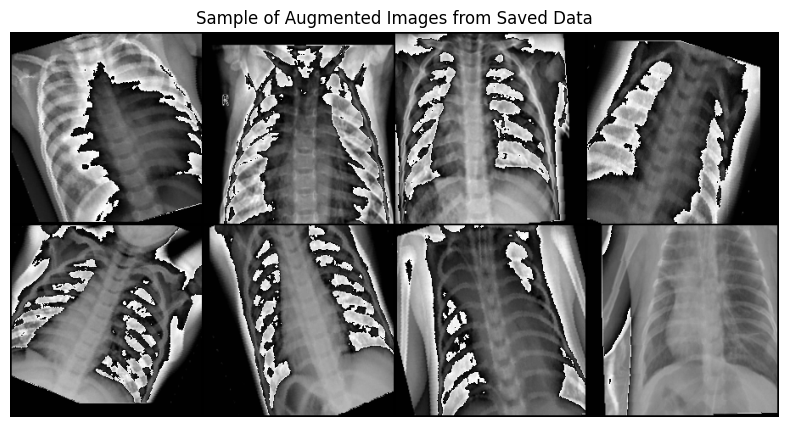

In [1]:
import os
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

# Define transformations to load images without further augmenting them
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((224, 224)),                # Ensure consistent size
    transforms.ToTensor(),                        # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])   # Normalize to match the saved scaling
])

# Load the saved augmented dataset
augmented_dataset = datasets.ImageFolder(root='/home/user/persistent/chest_xray/chest_xray/augmented/train', transform=transform)

# Create a DataLoader to retrieve a batch of images
loader = DataLoader(augmented_dataset, batch_size=8, shuffle=True)

# Function to visualize a batch of augmented images
def visualize_saved_augmented_images(loader, num_images=8):
    images, labels = next(iter(loader))  # Get a batch of images from the loader
    images = images[:num_images]  # Take a specified number of images
    grid_img = make_grid(images, nrow=4, padding=2, normalize=True)  # Arrange in grid
    plt.figure(figsize=(10, 5))
    plt.imshow(grid_img.permute(1, 2, 0), cmap="gray")  # Permute for correct shape
    plt.axis("off")
    plt.title("Sample of Augmented Images from Saved Data")
    plt.show()

# Visualize the images
visualize_saved_augmented_images(loader)


In [3]:
# data_loaders_and_training.py

# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import nbimporter
from model import PneumoniaDetectionCNN
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import csv

def train_model(device):
    # Paths to the transformed data directories
    train_data_path = '/home/user/persistent/chest_xray/chest_xray/augmented/train'
    val_data_path = '/home/user/persistent/chest_xray/chest_xray/augmented/val'
    test_data_path = '/home/user/persistent/chest_xray/chest_xray/augmented/test'

    # Define transformations (already transformed, just converting to tensor and normalizing)
    base_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),  # Ensure grayscale consistency
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])   # Normalize as per the previous transformation
    ])

    # Load the training, validation, and test datasets from transformed directories
    train_dataset = datasets.ImageFolder(root=train_data_path, transform=base_transform)
    val_dataset = datasets.ImageFolder(root=val_data_path, transform=base_transform)
    test_dataset = datasets.ImageFolder(root=test_data_path, transform=base_transform)

    # Create DataLoader objects
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

    # Print dataset sizes
    print(f'Number of images in training set: {len(train_dataset)}')
    print(f'Number of images in validation set: {len(val_dataset)}')
    print(f'Number of images in test set: {len(test_dataset)}')

    # Define the number of folds for K-Fold Cross-Validation
    k_folds = 5
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    # Lists to store average results across all folds
    fold_accuracies = []
    fold_val_losses = []

    # Iterate over each fold
    for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
        print(f'\nFold {fold + 1}/{k_folds}')
        
        # Create subsets for this fold
        train_sub = Subset(train_dataset, train_idx)
        val_sub = Subset(train_dataset, val_idx)
        
        # Create DataLoader objects for the current fold
        train_loader = DataLoader(train_sub, batch_size=32, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_sub, batch_size=32, shuffle=False, num_workers=4)
        
        # Initialize the model
        model = PneumoniaDetectionCNN().to(device)
        criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
        optimizer = optim.RMSprop(model.parameters(), lr=0.001)
        
        # Training parameters
        num_epochs = 25
        best_fold_accuracy = 0.0
        
        # Training loop for the current fold
        train_losses = []
        val_losses = []
        val_accuracies = []
        
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
                
                # Zero the gradients
                optimizer.zero_grad()
                
                # Forward pass
                outputs = model(images)
                
                # Calculate loss
                loss = criterion(outputs, labels)
                
                # Backward pass and optimization
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
            
            train_losses.append(running_loss / len(train_loader))
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_losses[-1]:.4f}')
            
            # Validation loop
            model.eval()
            val_loss = 0.0
            correct = 0
            total = 0
            
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
                    outputs = model(images)
                    val_loss += criterion(outputs, labels).item()
                    predicted = (outputs > 0.5).int()
                    total += labels.size(0)
                    correct += (predicted == labels.int()).sum().item()
            
            val_losses.append(val_loss / len(val_loader))
            val_accuracy = 100 * correct / total
            val_accuracies.append(val_accuracy)
            print(f'Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
            
            # Save the best model for this fold
            if val_accuracy > best_fold_accuracy:
                best_fold_accuracy = val_accuracy
                torch.save(model.state_dict(), f'best_model_fold_{fold + 1}.pth')
                print('Best model for this fold saved!')
        
        fold_accuracies.append(best_fold_accuracy)
        fold_val_losses.append(min(val_losses))

    # Calculate average results across all folds
    average_accuracy = sum(fold_accuracies) / k_folds
    average_val_loss = sum(fold_val_losses) / k_folds

    print(f'\nAverage Validation Accuracy across {k_folds} folds: {average_accuracy:.2f}%')
    print(f'Average Validation Loss across {k_folds} folds: {average_val_loss:.4f}')

    # Save overall results to a CSV file
    with open('kfold_results.csv', 'w', newline='') as csvfile:
        fieldnames = ['fold', 'val_accuracy', 'val_loss']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for fold in range(k_folds):
            writer.writerow({'fold': fold + 1, 'val_accuracy': fold_accuracies[fold], 'val_loss': fold_val_losses[fold]})

    print('K-Fold Cross-Validation complete and results saved.')

# Direct function call for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_model(device)


Number of images in training set: 5216
Number of images in validation set: 16
Number of images in test set: 624

Fold 1/5
Epoch [1/25], Loss: 49.4347
Validation Loss: 51.7045, Validation Accuracy: 47.70%
Best model for this fold saved!
Epoch [2/25], Loss: 50.5725
Validation Loss: 51.7045, Validation Accuracy: 47.70%
Epoch [3/25], Loss: 50.4532
Validation Loss: 51.7045, Validation Accuracy: 47.70%
Epoch [4/25], Loss: 50.4930
Validation Loss: 51.7045, Validation Accuracy: 47.70%
Epoch [5/25], Loss: 50.4930
Validation Loss: 51.7045, Validation Accuracy: 47.70%
Epoch [6/25], Loss: 50.4532
Validation Loss: 51.7045, Validation Accuracy: 47.70%
Epoch [7/25], Loss: 50.5328
Validation Loss: 51.7045, Validation Accuracy: 47.70%
Epoch [8/25], Loss: 50.5328
Validation Loss: 51.7045, Validation Accuracy: 47.70%
Epoch [9/25], Loss: 50.4930
Validation Loss: 51.7045, Validation Accuracy: 47.70%
Epoch [10/25], Loss: 50.5328
Validation Loss: 51.7045, Validation Accuracy: 47.70%
Epoch [11/25], Loss: 50.4

In [10]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid
import numpy as np

# Function to unnormalize images for visualization
def unnormalize(img):
    img = img * 0.5 + 0.5  # Undo normalization (mean=[0.5], std=[0.5])
    img = torch.clamp(img, 0, 1)  # Ensure values are in [0, 1]
    return img

# Function to display a grid of augmented images from a DataLoader
def show_augmented_images(loader, num_images=8):
    # Get a batch of images and labels
    images, labels = next(iter(loader))
    
    # Unnormalize the images for display
    images = torch.stack([unnormalize(img) for img in images])

    # Create a grid of images
    grid_img = make_grid(images[:num_images], nrow=4, padding=2)
    npimg = grid_img.numpy()
    
    # Display the images
    plt.figure(figsize=(12, 6))
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.axis('off')
    plt.title("Augmented Images from Training Set")
    plt.show()

# Display augmented images (assuming train_loader is already loaded with augmentations)
show_augmented_images(train_loader, num_images=8)


NameError: name 'train_loader' is not defined

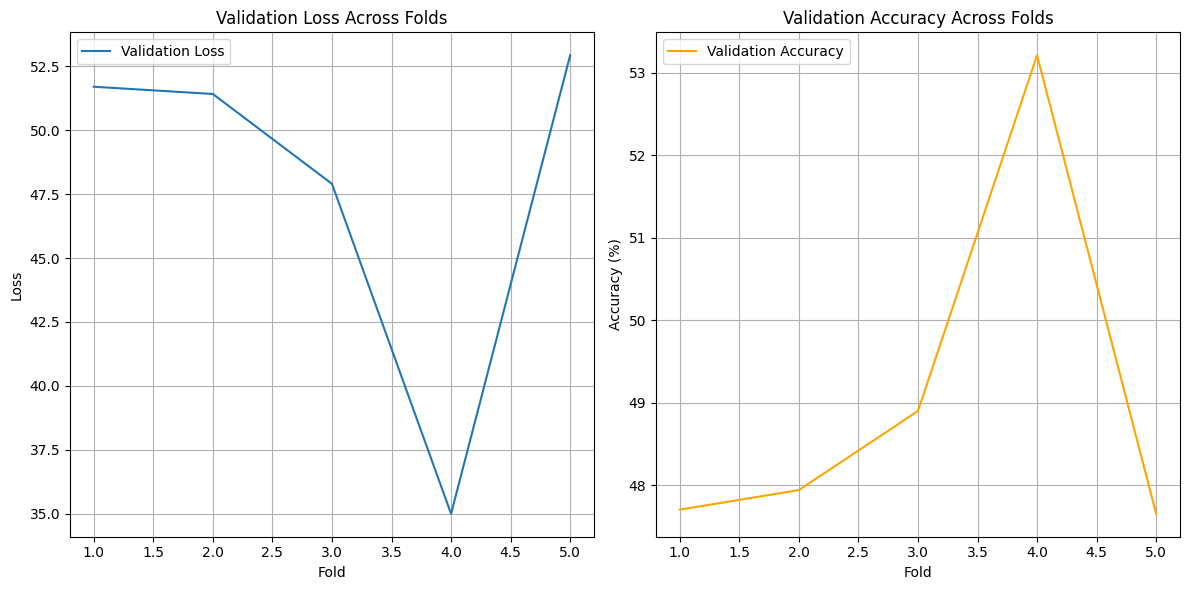

In [1]:
import matplotlib.pyplot as plt
import csv

# Read the training metrics from the CSV file
train_losses = []
val_losses = []
val_accuracies = []

# Replace 'training_metrics.csv' with your CSV file if you saved the data during training
with open('kfold_results.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        val_losses.append(float(row['val_loss']))
        val_accuracies.append(float(row['val_accuracy']))

# Generate the plot for losses
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.title('Validation Loss Across Folds')
plt.grid(True)
plt.legend()

# Generate the plot for accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Fold')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Across Folds')
plt.grid(True)
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [3]:
import os
import shutil
import random

# Paths to the augmented dataset directories
train_dir = '/home/user/persistent/chest_xray/chest_xray/augmented/train'
val_dir = '/home/user/persistent/chest_xray/chest_xray/augmented/val'

# Transfer 10% of images from train to val
def transfer_images(src_dir, dest_dir, transfer_ratio=0.1):
    for category in os.listdir(src_dir):
        category_src_path = os.path.join(src_dir, category)
        category_dest_path = os.path.join(dest_dir, category)

        # Create the category directory in the destination if it doesn't exist
        if not os.path.exists(category_dest_path):
            os.makedirs(category_dest_path)

        if os.path.isdir(category_src_path):
            # List all image files in the category directory
            image_files = [f for f in os.listdir(category_src_path) if os.path.isfile(os.path.join(category_src_path, f))]
            num_to_transfer = int(len(image_files) * transfer_ratio)
            
            # Randomly select images to transfer
            images_to_transfer = random.sample(image_files, num_to_transfer)
            
            for image in images_to_transfer:
                src_image_path = os.path.join(category_src_path, image)
                dest_image_path = os.path.join(category_dest_path, image)
                
                # Move the image file from train to val
                shutil.move(src_image_path, dest_image_path)
            
            print(f'Transferred {num_to_transfer} images from {category_src_path} to {category_dest_path}')

# Function to count the number of images in a directory and its subdirectories
def count_images_in_directory(directory):
    total_count = 0
    for root, dirs, files in os.walk(directory):
        total_count += len([file for file in files if file.endswith(('.png', '.jpg', '.jpeg'))])
    return total_count

# Run the transfer function
transfer_images(train_dir, val_dir, transfer_ratio=0.1)

# Verify the number of images in each set after transfer
print("\nUpdated counts:")
train_count = count_images_in_directory(train_dir)
val_count = count_images_in_directory(val_dir)

print(f'Number of images in training set after transfer: {train_count}')
print(f'Number of images in validation set after transfer: {val_count}')


Transferred 230 images from /home/user/persistent/chest_xray/chest_xray/augmented/train/1 to /home/user/persistent/chest_xray/chest_xray/augmented/val/1
Transferred 238 images from /home/user/persistent/chest_xray/chest_xray/augmented/train/0 to /home/user/persistent/chest_xray/chest_xray/augmented/val/0

Updated counts:
Number of images in training set after transfer: 4227
Number of images in validation set after transfer: 1003


In [2]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import nbimporter
from model import PneumoniaDetectionCNN
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import csv

def plot_metrics(train_losses, val_losses, val_accuracies):
    # Plot training and validation loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).int()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    acc = accuracy_score(all_labels, all_preds)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1-Score: {f1:.2f}')
    print(f'Accuracy: {acc:.2f}')

    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
def train_model2(device):
    # Paths to the transformed data directories
    train_data_path = '/home/user/persistent/chest_xray/chest_xray/augmented/train'
    val_data_path = '/home/user/persistent/chest_xray/chest_xray/augmented/val'
    test_data_path = '/home/user/persistent/chest_xray/chest_xray/augmented/test'

    # Define transformations (already transformed, just converting to tensor and normalizing)
    base_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),  # Ensure grayscale consistency
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])   # Normalize as per the previous transformation
    ])

    # Load the training, validation, and test datasets from transformed directories
    train_dataset = datasets.ImageFolder(root=train_data_path, transform=base_transform)
    val_dataset = datasets.ImageFolder(root=val_data_path, transform=base_transform)
    test_dataset = datasets.ImageFolder(root=test_data_path, transform=base_transform)

    # Create DataLoader objects
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

    # Print dataset sizes
    print(f'Number of images in training set: {len(train_dataset)}')
    print(f'Number of images in validation set: {len(val_dataset)}')
    print(f'Number of images in test set: {len(test_dataset)}')

    # Define the number of folds for K-Fold Cross-Validation
    k_folds = 5
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    # Lists to store average results across all folds
    fold_accuracies = []
    fold_val_losses = []

    # Iterate over each fold
    for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
        print(f'\nFold {fold + 1}/{k_folds}')
        
        # Create subsets for this fold
        train_sub = Subset(train_dataset, train_idx)
        val_sub = Subset(train_dataset, val_idx)
        
        # Create DataLoader objects for the current fold
        train_loader = DataLoader(train_sub, batch_size=32, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_sub, batch_size=32, shuffle=False, num_workers=4)
        
        # Initialize the model
        model = PneumoniaDetectionCNN().to(device)
        criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
        optimizer = optim.RMSprop(model.parameters(), lr=0.000001)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.3, verbose=True)
        
        # Training parameters
        num_epochs = 25
        best_fold_accuracy = 0.0
        
        # Training loop for the current fold
        train_losses = []
        val_losses = []
        val_accuracies = []
        
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
                
                # Zero the gradients
                optimizer.zero_grad()
                
                # Forward pass
                outputs = model(images)
                
                # Calculate loss
                loss = criterion(outputs, labels)
                
                # Backward pass and optimization
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
            
            train_losses.append(running_loss / len(train_loader))
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_losses[-1]:.4f}')
            
            # Validation loop
            model.eval()
            val_loss = 0.0
            correct = 0
            total = 0
            
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
                    outputs = model(images)
                    val_loss += criterion(outputs, labels).item()
                    predicted = (outputs > 0.5).int()
                    total += labels.size(0)
                    correct += (predicted == labels.int()).sum().item()
            
            val_losses.append(val_loss / len(val_loader))
            val_accuracy = 100 * correct / total
            val_accuracies.append(val_accuracy)
            print(f'Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
            
            # Step the learning rate scheduler
            scheduler.step(val_accuracy)
            
            # Save the best model for this fold
            if val_accuracy > best_fold_accuracy:
                best_fold_accuracy = val_accuracy
                torch.save(model.state_dict(), f'best_model_fold_{fold + 1}.pth')
                print('Best model for this fold saved!')
        
        fold_accuracies.append(best_fold_accuracy)
        fold_val_losses.append(min(val_losses))

    # Calculate average results across all folds
    average_accuracy = sum(fold_accuracies) / k_folds
    average_val_loss = sum(fold_val_losses) / k_folds

    print(f'\nAverage Validation Accuracy across {k_folds} folds: {average_accuracy:.2f}%')
    print(f'Average Validation Loss across {k_folds} folds: {average_val_loss:.4f}')

    # Save overall results to a CSV file
    with open('kfold_results2.csv', 'w', newline='') as csvfile:
        fieldnames = ['fold', 'val_accuracy', 'val_loss']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for fold in range(k_folds):
            writer.writerow({'fold': fold + 1, 'val_accuracy': fold_accuracies[fold], 'val_loss': fold_val_losses[fold]})

    print('K-Fold Cross-Validation complete and results saved.')

# Direct function call for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_model2(device)


Number of images in training set: 4227
Number of images in validation set: 1003
Number of images in test set: 624

Fold 1/5
Epoch [1/25], Loss: 0.6698
Validation Loss: 0.6580, Validation Accuracy: 68.56%
Best model for this fold saved!
Epoch [2/25], Loss: 0.6335
Validation Loss: 0.6457, Validation Accuracy: 61.94%
Epoch [3/25], Loss: 0.6078
Validation Loss: 0.6424, Validation Accuracy: 53.43%
Epoch [4/25], Loss: 0.5831
Validation Loss: 0.6192, Validation Accuracy: 61.35%
Epoch 00004: reducing learning rate of group 0 to 3.0000e-07.
Epoch [5/25], Loss: 0.5674
Validation Loss: 0.6329, Validation Accuracy: 53.07%
Epoch [6/25], Loss: 0.5623
Validation Loss: 0.6210, Validation Accuracy: 56.26%
Epoch [7/25], Loss: 0.5548
Validation Loss: 0.6217, Validation Accuracy: 54.96%
Epoch 00007: reducing learning rate of group 0 to 9.0000e-08.
Epoch [8/25], Loss: 0.5521
Validation Loss: 0.6225, Validation Accuracy: 54.61%
Epoch [9/25], Loss: 0.5520
Validation Loss: 0.6257, Validation Accuracy: 53.78%


Number of images in training set: 4227
Number of images in validation set: 1003
Number of images in test set: 624

Fold 1/5
Epoch [1/25], Loss: 0.6283
Validation Loss: 0.6827, Validation Accuracy: 46.81%
Best model for this fold saved!
Epoch [2/25], Loss: 0.5692
Validation Loss: 0.5765, Validation Accuracy: 46.81%
Epoch [3/25], Loss: 0.5552
Validation Loss: 0.5852, Validation Accuracy: 46.81%
Epoch [4/25], Loss: 0.5495
Validation Loss: 0.5695, Validation Accuracy: 46.81%
Epoch [5/25], Loss: 0.5456
Validation Loss: 0.6968, Validation Accuracy: 46.81%
Epoch 00005: reducing learning rate of group 0 to 3.0000e-05.
Epoch [6/25], Loss: 0.5423
Validation Loss: 0.5578, Validation Accuracy: 46.81%
Epoch [7/25], Loss: 0.5395
Validation Loss: 0.5951, Validation Accuracy: 46.81%
Epoch [8/25], Loss: 0.5368
Validation Loss: 0.5671, Validation Accuracy: 46.81%
Epoch [9/25], Loss: 0.5380
Validation Loss: 0.6443, Validation Accuracy: 46.81%
Epoch 00009: reducing learning rate of group 0 to 9.0000e-06.


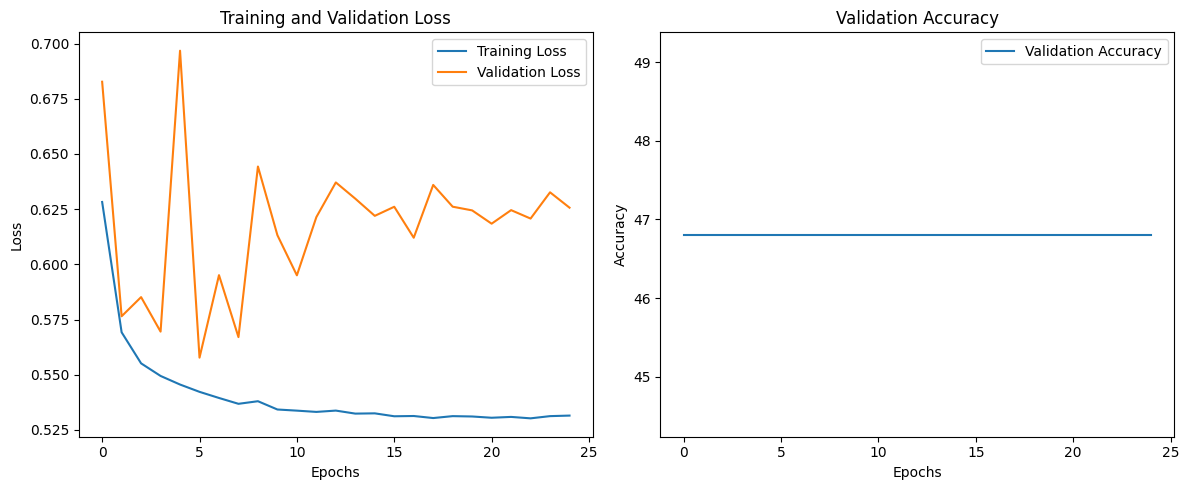

Precision: 0.47
Recall: 1.00
F1-Score: 0.64
Accuracy: 0.47


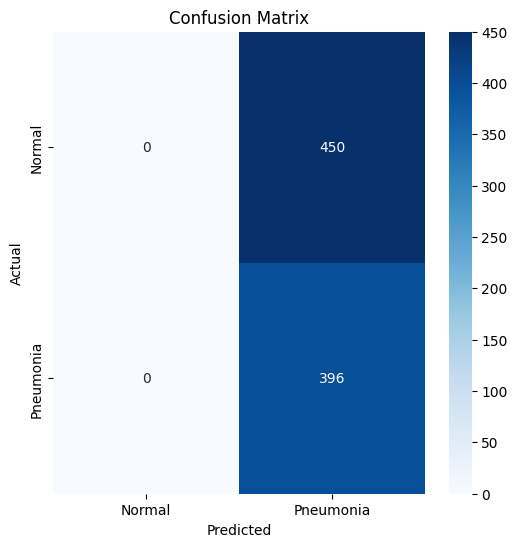


Fold 2/5
Epoch [1/25], Loss: 0.6249
Validation Loss: 0.6269, Validation Accuracy: 49.17%
Best model for this fold saved!
Epoch [2/25], Loss: 0.5688
Validation Loss: 0.5851, Validation Accuracy: 49.17%
Epoch [3/25], Loss: 0.5576
Validation Loss: 0.6664, Validation Accuracy: 49.17%
Epoch [4/25], Loss: 0.5501
Validation Loss: 0.7542, Validation Accuracy: 49.17%
Epoch [5/25], Loss: 0.5476
Validation Loss: 0.7531, Validation Accuracy: 49.17%
Epoch 00005: reducing learning rate of group 0 to 3.0000e-05.
Epoch [6/25], Loss: 0.5427
Validation Loss: 0.6338, Validation Accuracy: 49.17%
Epoch [7/25], Loss: 0.5404
Validation Loss: 0.7353, Validation Accuracy: 49.17%
Epoch [8/25], Loss: 0.5409
Validation Loss: 0.6942, Validation Accuracy: 49.17%
Epoch [9/25], Loss: 0.5379
Validation Loss: 0.6471, Validation Accuracy: 49.17%
Epoch 00009: reducing learning rate of group 0 to 9.0000e-06.
Epoch [10/25], Loss: 0.5370
Validation Loss: 0.6614, Validation Accuracy: 49.17%
Epoch [11/25], Loss: 0.5370
Valid

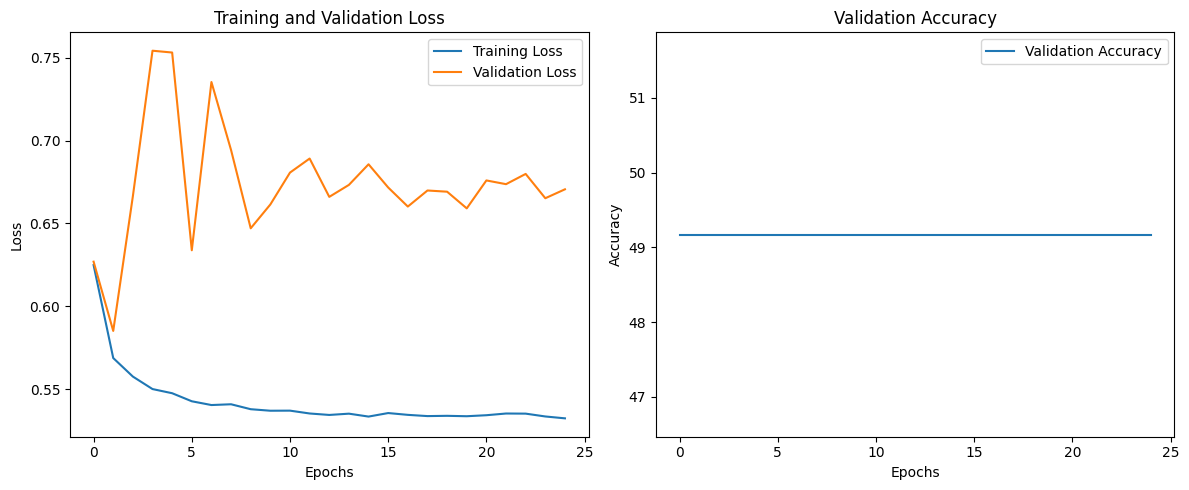

Precision: 0.49
Recall: 1.00
F1-Score: 0.66
Accuracy: 0.49


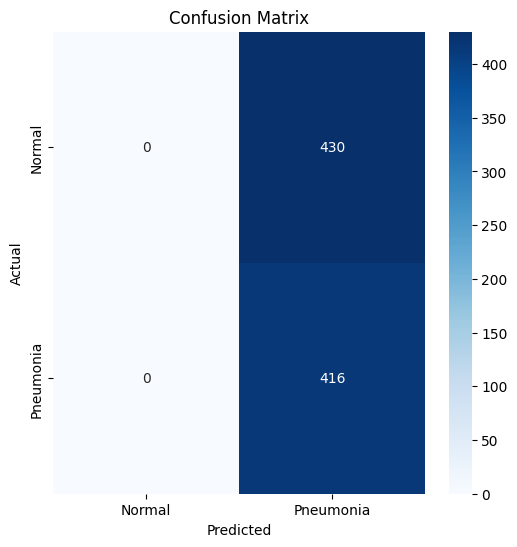


Fold 3/5
Epoch [1/25], Loss: 0.6308
Validation Loss: 0.6161, Validation Accuracy: 51.01%
Best model for this fold saved!
Epoch [2/25], Loss: 0.5709
Validation Loss: 0.6400, Validation Accuracy: 51.01%
Epoch [3/25], Loss: 0.5588
Validation Loss: 0.5524, Validation Accuracy: 51.01%
Epoch [4/25], Loss: 0.5553
Validation Loss: 0.5592, Validation Accuracy: 51.01%
Epoch [5/25], Loss: 0.5512
Validation Loss: 0.5547, Validation Accuracy: 51.01%
Epoch 00005: reducing learning rate of group 0 to 3.0000e-05.
Epoch [6/25], Loss: 0.5463
Validation Loss: 0.5328, Validation Accuracy: 51.01%
Epoch [7/25], Loss: 0.5448
Validation Loss: 0.5604, Validation Accuracy: 51.01%
Epoch [8/25], Loss: 0.5422
Validation Loss: 0.6188, Validation Accuracy: 51.01%
Epoch [9/25], Loss: 0.5415
Validation Loss: 0.5903, Validation Accuracy: 51.01%
Epoch 00009: reducing learning rate of group 0 to 9.0000e-06.
Epoch [10/25], Loss: 0.5391
Validation Loss: 0.5915, Validation Accuracy: 51.01%
Epoch [11/25], Loss: 0.5385
Valid

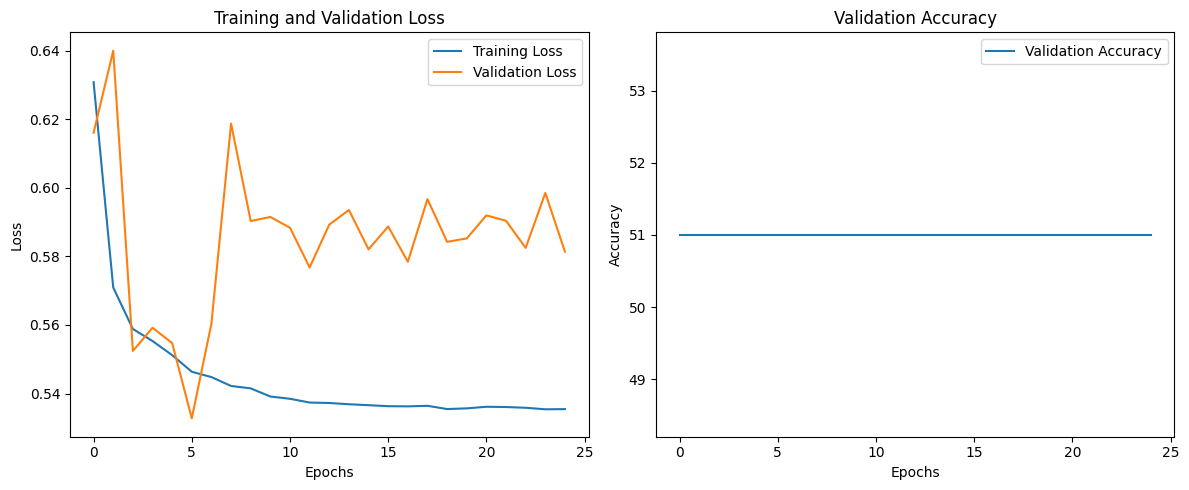

Precision: 0.51
Recall: 1.00
F1-Score: 0.68
Accuracy: 0.51


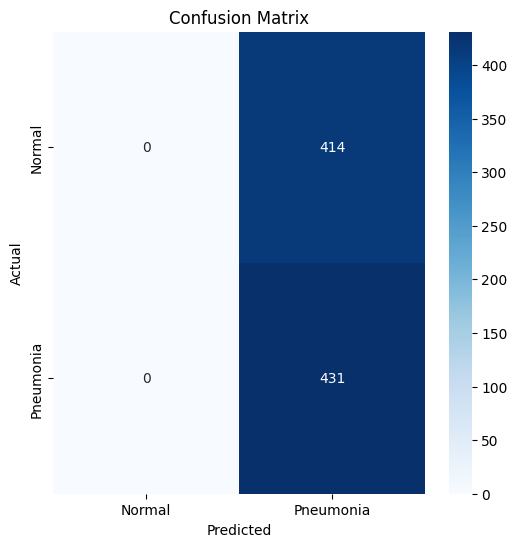


Fold 4/5
Epoch [1/25], Loss: 0.6276
Validation Loss: 0.6565, Validation Accuracy: 48.76%
Best model for this fold saved!
Epoch [2/25], Loss: 0.5698
Validation Loss: 0.5927, Validation Accuracy: 48.76%
Epoch [3/25], Loss: 0.5576
Validation Loss: 0.5940, Validation Accuracy: 48.76%
Epoch [4/25], Loss: 0.5494
Validation Loss: 0.5549, Validation Accuracy: 48.76%
Epoch [5/25], Loss: 0.5474
Validation Loss: 0.5812, Validation Accuracy: 48.76%
Epoch 00005: reducing learning rate of group 0 to 3.0000e-05.
Epoch [6/25], Loss: 0.5429
Validation Loss: 0.5589, Validation Accuracy: 48.76%
Epoch [7/25], Loss: 0.5393
Validation Loss: 0.5703, Validation Accuracy: 48.76%
Epoch [8/25], Loss: 0.5380
Validation Loss: 0.5515, Validation Accuracy: 48.76%
Epoch [9/25], Loss: 0.5403
Validation Loss: 0.5660, Validation Accuracy: 48.76%
Epoch 00009: reducing learning rate of group 0 to 9.0000e-06.
Epoch [10/25], Loss: 0.5379
Validation Loss: 0.5799, Validation Accuracy: 48.76%
Epoch [11/25], Loss: 0.5345
Valid

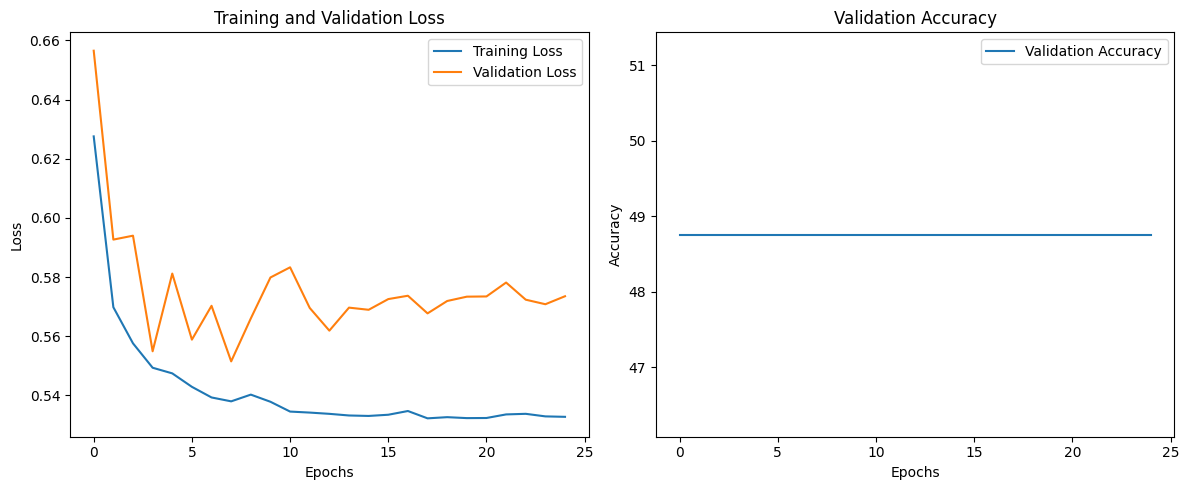

Precision: 0.49
Recall: 1.00
F1-Score: 0.66
Accuracy: 0.49


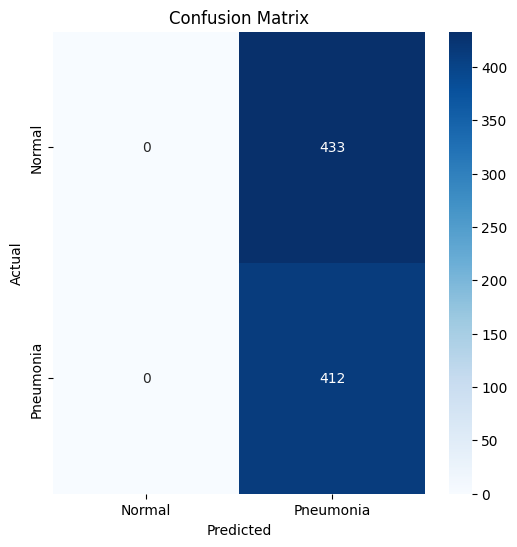


Fold 5/5
Epoch [1/25], Loss: 0.6342
Validation Loss: 0.7524, Validation Accuracy: 50.18%
Best model for this fold saved!
Epoch [2/25], Loss: 0.5701
Validation Loss: 0.6474, Validation Accuracy: 50.18%
Epoch [3/25], Loss: 0.5559
Validation Loss: 0.5603, Validation Accuracy: 50.18%
Epoch [4/25], Loss: 0.5506
Validation Loss: 0.5482, Validation Accuracy: 50.18%
Epoch [5/25], Loss: 0.5480
Validation Loss: 0.6426, Validation Accuracy: 50.18%
Epoch 00005: reducing learning rate of group 0 to 3.0000e-05.
Epoch [6/25], Loss: 0.5414
Validation Loss: 0.6502, Validation Accuracy: 50.18%
Epoch [7/25], Loss: 0.5395
Validation Loss: 0.5922, Validation Accuracy: 50.18%
Epoch [8/25], Loss: 0.5394
Validation Loss: 0.6757, Validation Accuracy: 50.18%
Epoch [9/25], Loss: 0.5400
Validation Loss: 0.6425, Validation Accuracy: 50.18%
Epoch 00009: reducing learning rate of group 0 to 9.0000e-06.
Epoch [10/25], Loss: 0.5362
Validation Loss: 0.6425, Validation Accuracy: 50.18%
Epoch [11/25], Loss: 0.5346
Valid

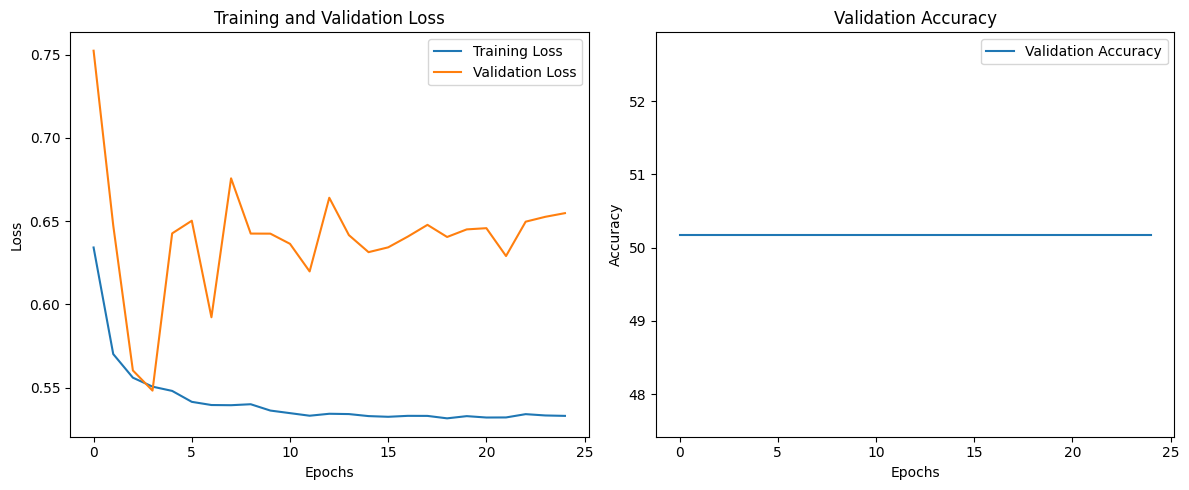

Precision: 0.50
Recall: 1.00
F1-Score: 0.67
Accuracy: 0.50


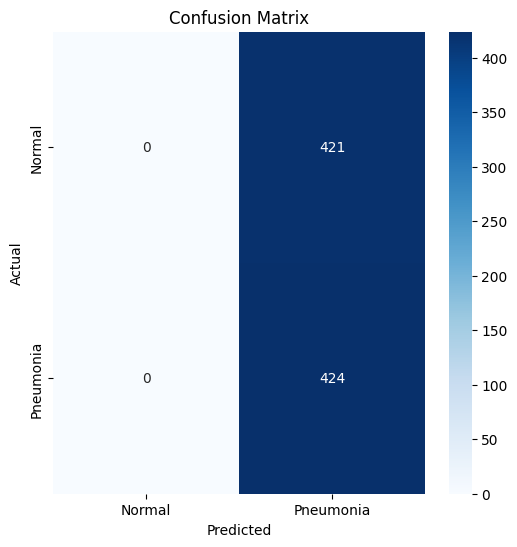


Average Validation Accuracy across 5 folds: 49.18%
Average Validation Loss across 5 folds: 0.5551
K-Fold Cross-Validation complete and results saved.


In [4]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import csv
import nbimporter
from model import ImprovedPneumoniaDetectionCNN
from sklearn.model_selection import KFold

def plot_metrics(train_losses, val_losses, val_accuracies):
    # Plot training and validation loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).int()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    acc = accuracy_score(all_labels, all_preds)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1-Score: {f1:.2f}')
    print(f'Accuracy: {acc:.2f}')

    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

def train_model3(device):
    # Paths to the transformed data directories
    train_data_path = '/home/user/persistent/chest_xray/chest_xray/augmented/train'
    val_data_path = '/home/user/persistent/chest_xray/chest_xray/augmented/val'
    test_data_path = '/home/user/persistent/chest_xray/chest_xray/augmented/test'

    # Define transformations (consistent with the previous normalization)
    base_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),  # Ensure grayscale consistency
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])   # Normalize as per the previous transformation
    ])

    # Load the training, validation, and test datasets from transformed directories
    train_dataset = datasets.ImageFolder(root=train_data_path, transform=base_transform)
    val_dataset = datasets.ImageFolder(root=val_data_path, transform=base_transform)
    test_dataset = datasets.ImageFolder(root=test_data_path, transform=base_transform)

    # Create DataLoader objects
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

    # Print dataset sizes
    print(f'Number of images in training set: {len(train_dataset)}')
    print(f'Number of images in validation set: {len(val_dataset)}')
    print(f'Number of images in test set: {len(test_dataset)}')

    # Define the number of folds for K-Fold Cross-Validation
    k_folds = 5
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    # Lists to store average results across all folds
    fold_accuracies = []
    fold_val_losses = []

    # Iterate over each fold
    for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
        print(f'\nFold {fold + 1}/{k_folds}')
        
        # Create subsets for this fold
        train_sub = Subset(train_dataset, train_idx)
        val_sub = Subset(train_dataset, val_idx)
        
        # Create DataLoader objects for the current fold
        train_loader = DataLoader(train_sub, batch_size=32, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_sub, batch_size=32, shuffle=False, num_workers=4)
        
        # Initialize the model
        model = ImprovedPneumoniaDetectionCNN().to(device)
        criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for better stability
        optimizer = optim.AdamW(model.parameters(), lr=0.0001)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.3, verbose=True)
        
        # Training parameters
        num_epochs = 25
        best_fold_accuracy = 0.0
        
        # Training loop for the current fold
        train_losses = []
        val_losses = []
        val_accuracies = []
        
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
                
                # Zero the gradients
                optimizer.zero_grad()
                
                # Forward pass
                outputs = model(images)
                
                # Calculate loss
                loss = criterion(outputs, labels)
                
                # Backward pass and optimization
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
            
            train_losses.append(running_loss / len(train_loader))
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_losses[-1]:.4f}')
            
            # Validation loop
            model.eval()
            val_loss = 0.0
            correct = 0
            total = 0
            
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
                    outputs = model(images)
                    val_loss += criterion(outputs, labels).item()
                    predicted = (torch.sigmoid(outputs) > 0.5).int()
                    total += labels.size(0)
                    correct += (predicted == labels.int()).sum().item()
            
            val_losses.append(val_loss / len(val_loader))
            val_accuracy = 100 * correct / total
            val_accuracies.append(val_accuracy)
            print(f'Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
            
            # Step the learning rate scheduler
            scheduler.step(val_accuracy)
            
            # Save the best model for this fold
            if val_accuracy > best_fold_accuracy:
                best_fold_accuracy = val_accuracy
                torch.save(model.state_dict(), f'best_model_fold_{fold + 1}.pth')
                print('Best model for this fold saved!')
        
        fold_accuracies.append(best_fold_accuracy)
        fold_val_losses.append(min(val_losses))

        # Plot metrics after each fold
        plot_metrics(train_losses, val_losses, val_accuracies)

        # Evaluate on validation set
        evaluate_model(model, val_loader, device)

    # Calculate average results across all folds
    average_accuracy = sum(fold_accuracies) / k_folds
    average_val_loss = sum(fold_val_losses) / k_folds

    print(f'\nAverage Validation Accuracy across {k_folds} folds: {average_accuracy:.2f}%')
    print(f'Average Validation Loss across {k_folds} folds: {average_val_loss:.4f}')

    # Save overall results to a CSV file
    with open('kfold_results3.csv', 'w', newline='') as csvfile:
        fieldnames = ['fold', 'val_accuracy', 'val_loss']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for fold in range(k_folds):
            writer.writerow({'fold': fold + 1, 'val_accuracy': fold_accuracies[fold], 'val_loss': fold_val_losses[fold]})

    print('K-Fold Cross-Validation complete and results saved.')

# Direct function call for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_model3(device)


In [5]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import nbimporter
from model import ImprovedPneumoniaDetectionCNN3
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import csv

def plot_metrics(train_losses, val_losses, val_accuracies):
    # Plot training and validation loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).int()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    acc = accuracy_score(all_labels, all_preds)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1-Score: {f1:.2f}')
    print(f'Accuracy: {acc:.2f}')

    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
def train_model4(device):
    # Paths to the transformed data directories
    train_data_path = '/home/user/persistent/chest_xray/chest_xray/augmented/train'
    val_data_path = '/home/user/persistent/chest_xray/chest_xray/augmented/val'
    test_data_path = '/home/user/persistent/chest_xray/chest_xray/augmented/test'

    # Define transformations (already transformed, just converting to tensor and normalizing)
    base_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),  # Ensure grayscale consistency
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])   # Normalize as per the previous transformation
    ])

    # Load the training, validation, and test datasets from transformed directories
    train_dataset = datasets.ImageFolder(root=train_data_path, transform=base_transform)
    val_dataset = datasets.ImageFolder(root=val_data_path, transform=base_transform)
    test_dataset = datasets.ImageFolder(root=test_data_path, transform=base_transform)

    # Create DataLoader objects
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

    # Print dataset sizes
    print(f'Number of images in training set: {len(train_dataset)}')
    print(f'Number of images in validation set: {len(val_dataset)}')
    print(f'Number of images in test set: {len(test_dataset)}')

    # Define the number of folds for K-Fold Cross-Validation
    k_folds = 5
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    # Lists to store average results across all folds
    fold_accuracies = []
    fold_val_losses = []

    # Iterate over each fold
    for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
        print(f'\nFold {fold + 1}/{k_folds}')
        
        # Create subsets for this fold
        train_sub = Subset(train_dataset, train_idx)
        val_sub = Subset(train_dataset, val_idx)
        
        # Create DataLoader objects for the current fold
        train_loader = DataLoader(train_sub, batch_size=32, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_sub, batch_size=32, shuffle=False, num_workers=4)
        
        # Initialize the model
        model = ImprovedPneumoniaDetectionCNN3().to(device)
        criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
        optimizer = optim.RMSprop(model.parameters(), lr=0.000001)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.3, verbose=True)
        
        # Training parameters
        num_epochs = 25
        best_fold_accuracy = 0.0
        
        # Training loop for the current fold
        train_losses = []
        val_losses = []
        val_accuracies = []
        
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
                
                # Zero the gradients
                optimizer.zero_grad()
                
                # Forward pass
                outputs = model(images)
                
                # Calculate loss
                loss = criterion(outputs, labels)
                
                # Backward pass and optimization
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
            
            train_losses.append(running_loss / len(train_loader))
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_losses[-1]:.4f}')
            
            # Validation loop
            model.eval()
            val_loss = 0.0
            correct = 0
            total = 0
            
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
                    outputs = model(images)
                    val_loss += criterion(outputs, labels).item()
                    predicted = (outputs > 0.5).int()
                    total += labels.size(0)
                    correct += (predicted == labels.int()).sum().item()
            
            val_losses.append(val_loss / len(val_loader))
            val_accuracy = 100 * correct / total
            val_accuracies.append(val_accuracy)
            print(f'Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
            
            # Step the learning rate scheduler
            scheduler.step(val_accuracy)
            
            # Save the best model for this fold
            if val_accuracy > best_fold_accuracy:
                best_fold_accuracy = val_accuracy
                torch.save(model.state_dict(), f'best_model_fold_{fold + 1}.pth')
                print('Best model for this fold saved!')
        
        fold_accuracies.append(best_fold_accuracy)
        fold_val_losses.append(min(val_losses))

    # Calculate average results across all folds
    average_accuracy = sum(fold_accuracies) / k_folds
    average_val_loss = sum(fold_val_losses) / k_folds

    print(f'\nAverage Validation Accuracy across {k_folds} folds: {average_accuracy:.2f}%')
    print(f'Average Validation Loss across {k_folds} folds: {average_val_loss:.4f}')

    # Save overall results to a CSV file
    with open('kfold_results4.csv', 'w', newline='') as csvfile:
        fieldnames = ['fold', 'val_accuracy', 'val_loss']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for fold in range(k_folds):
            writer.writerow({'fold': fold + 1, 'val_accuracy': fold_accuracies[fold], 'val_loss': fold_val_losses[fold]})

    print('K-Fold Cross-Validation complete and results saved.')

# Direct function call for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_model4(device)


Number of images in training set: 4227
Number of images in validation set: 1003
Number of images in test set: 624

Fold 1/5
Epoch [1/25], Loss: 0.5851
Validation Loss: 0.5140, Validation Accuracy: 83.81%
Best model for this fold saved!
Epoch [2/25], Loss: 0.4732
Validation Loss: 0.4332, Validation Accuracy: 86.88%
Best model for this fold saved!
Epoch [3/25], Loss: 0.4146
Validation Loss: 0.3939, Validation Accuracy: 86.52%
Epoch [4/25], Loss: 0.3850
Validation Loss: 0.3677, Validation Accuracy: 87.83%
Best model for this fold saved!
Epoch [5/25], Loss: 0.3669
Validation Loss: 0.3515, Validation Accuracy: 88.53%
Best model for this fold saved!
Epoch [6/25], Loss: 0.3472
Validation Loss: 0.3402, Validation Accuracy: 88.30%
Epoch [7/25], Loss: 0.3333
Validation Loss: 0.3267, Validation Accuracy: 88.77%
Best model for this fold saved!
Epoch [8/25], Loss: 0.3294
Validation Loss: 0.3220, Validation Accuracy: 89.24%
Best model for this fold saved!
Epoch [9/25], Loss: 0.3150
Validation Loss: 

                            Model  Average Accuracy (%)  \
0           PneumoniaDetectionCNN             49.080019   
1        PneumoniaDetectionCNN_v2             65.412760   
2   ImprovedPneumoniaDetectionCNN             49.184383   
3  ImprovedPneumoniaDetectionCNN3             91.554101   

   Average Validation Loss  
0                47.792607  
1                 0.615052  
2                 0.555063  
3                 0.252331  


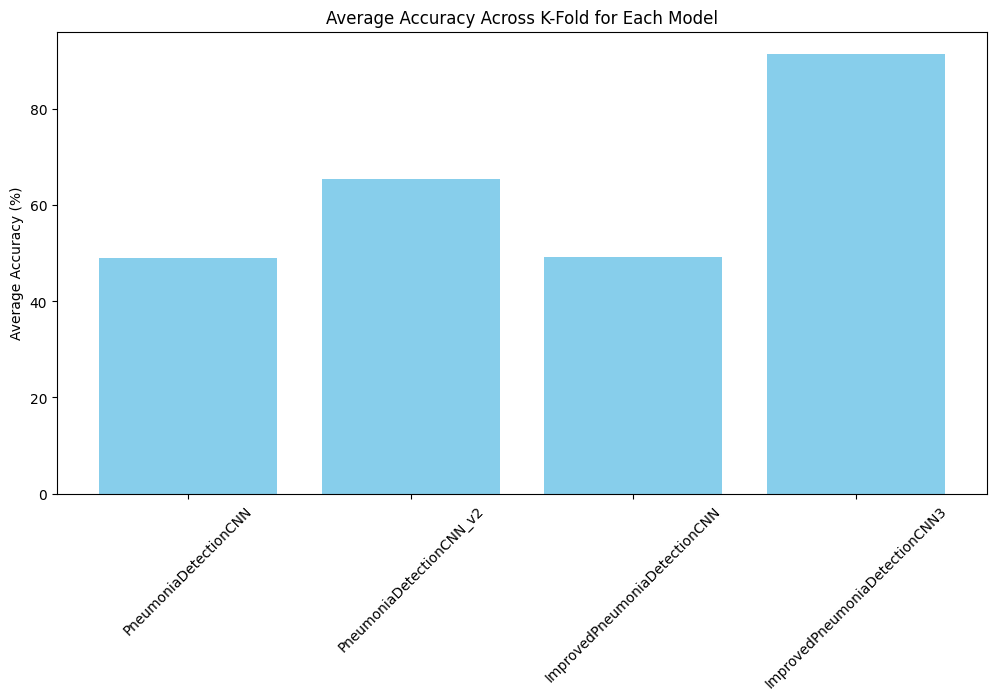

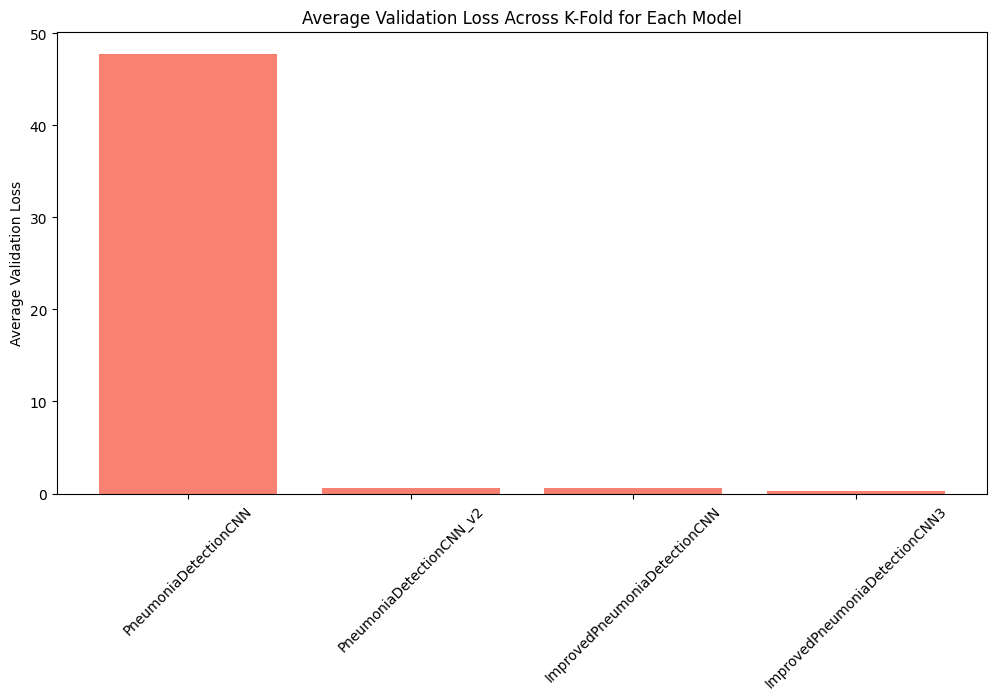

In [9]:
import pandas as pd

# Function to compute average accuracy and loss from a CSV file
def summarize_kfold_results(csv_file):
    results = pd.read_csv(csv_file)
    avg_accuracy = results['val_accuracy'].mean()
    avg_loss = results['val_loss'].mean()
    return avg_accuracy, avg_loss

# List of models and their CSV file names
models = {
    "PneumoniaDetectionCNN": "kfold_results.csv",
    "PneumoniaDetectionCNN_v2": "kfold_results2.csv",
    "ImprovedPneumoniaDetectionCNN": "kfold_results3.csv",
    "ImprovedPneumoniaDetectionCNN3": "kfold_results4.csv"
}

# Summarize results for each model
summary = []
for model_name, csv_file in models.items():
    avg_accuracy, avg_loss = summarize_kfold_results(csv_file)
    summary.append({
        "Model": model_name,
        "Average Accuracy (%)": avg_accuracy,
        "Average Validation Loss": avg_loss
    })

# Convert summary to DataFrame for better display
summary_df = pd.DataFrame(summary)
print(summary_df)

# Optional: Plot the summary results
import matplotlib.pyplot as plt

# Plot Average Accuracy
plt.figure(figsize=(12, 6))
plt.bar(summary_df["Model"], summary_df["Average Accuracy (%)"], color='skyblue')
plt.title("Average Accuracy Across K-Fold for Each Model")
plt.ylabel("Average Accuracy (%)")
plt.xticks(rotation=45)
plt.show()

# Plot Average Validation Loss
plt.figure(figsize=(12, 6))
plt.bar(summary_df["Model"], summary_df["Average Validation Loss"], color='salmon')
plt.title("Average Validation Loss Across K-Fold for Each Model")
plt.ylabel("Average Validation Loss")
plt.xticks(rotation=45)
plt.show()
